<a href="https://colab.research.google.com/github/ikonushok/AI-Traiding/blob/main/Pivot_points_testing_1h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading libraries

In [13]:
from IPython.display import clear_output
# отключение предупреждений
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Загрузка библиотек ai_tr_libs с github
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/Long_n_short_strategy.py
!curl --remote-name --location https://raw.githubusercontent.com/chekh/ai_tr_libs/main/Long_strategy.py
clear_output()

In [15]:
# https://kernc.github.io/backtesting.py/
!pip3 install backtesting
clear_output()

In [16]:
#!pip install tulipy
#clear_output()

# Подключение библиотек

In [37]:
from tensorflow.keras.models import load_model#, Sequential, Model
#from tensorflow.keras.layers import *
#from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#from tensorflow.keras import utils

#from keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from keras.preprocessing.sequence import TimeseriesGenerator

# Библиотеки backtesting
from backtesting import Backtest, Strategy

import matplotlib.pyplot as plt

import pandas as pd
from pandas import DataFrame as df
import numpy as np
import time
#from pandas import DataFrame as df

#import tulipy as tl

#from tensorflow.keras import backend as K


# Библиотеки из ai_tr_libs
from Long_n_short_strategy import Long_n_Short_Strategy as LnS
from Long_strategy import Long_Strategy as LS

# Общие данные

In [126]:
ticker = 'POLY.ME'
test_window = 220
val_window = 700
batch_size = 100
ensemble = 40

path_outputs = '/content/drive/MyDrive/AI_Trading/AI-trading_courses/4. НС и торговля по паттернам/Подбор оптимальных параметров/outputs/'
model_file_name = 'POLY.ME_Conc_1h.h5'

# Load dataset

In [127]:
# Загрузка только [Open, High, Low, Close]
data = pd.read_csv(path_outputs + 'signalsPOLY.ME_1h.csv', sep="\t")
data.columns=['Date', 'Open', 'High', 'Low', 'Close', 'Signal']

# Удаляем наниты
data.dropna(axis=0, inplace=True)
data = data.reset_index(drop=True)
data.Date = pd.to_datetime(data.Date).dt.strftime("%Y-%m-%d %H:%M")
data.Date = pd.to_datetime(data.Date)
data['Datetime'] = data['Date']
data.set_index('Datetime', inplace=True)
print(data.shape)
data

(3556, 6)


,Date,Open,High,Low,Close,Signal
Datetime,,,,,,
2020-01-03 13:30:00,2020-01-03 13:30:00,983.000000,988.599976,982.799988,986.400024,-1.0
2020-01-03 14:30:00,2020-01-03 14:30:00,986.000000,987.299988,984.700012,985.700012,-1.0
2020-01-03 15:30:00,2020-01-03 15:30:00,985.700012,986.799988,980.799988,981.299988,1.0
2020-01-03 16:30:00,2020-01-03 16:30:00,980.900024,985.000000,980.500000,981.500000,1.0
2020-01-03 17:30:00,2020-01-03 17:30:00,982.200012,987.500000,981.000000,985.200012,1.0
...,...,...,...,...,...,...
2021-06-04 14:30:00,2021-06-04 14:30:00,1728.800049,1731.199951,1724.900024,1725.099976,1.0
2021-06-04 15:30:00,2021-06-04 15:30:00,1725.199951,1759.800049,1725.199951,1755.400024,1.0
2021-06-04 16:30:00,2021-06-04 16:30:00,1756.000000,1759.900024,1753.900024,1759.000000,1.0


Text(0.5, 1.0, 'График цены на POLY.ME (1h)')

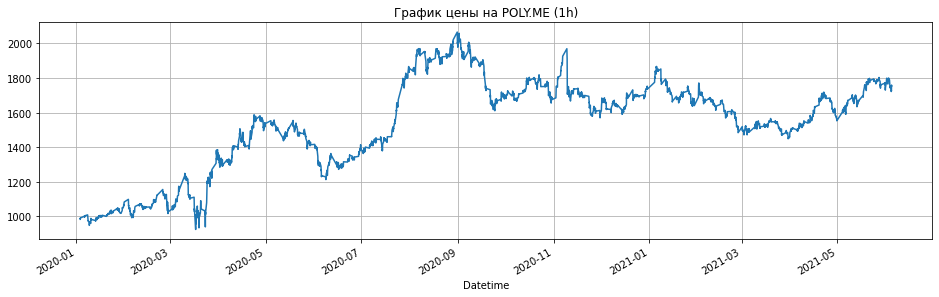

In [128]:
plt.figure(figsize=(16,6))
ax0 = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
#ax1 = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
data['Close'].plot(ax = ax0)
plt.grid()
plt.title('График цены на ' + ticker + ' (1h)')

# Functions

In [129]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
import numpy as np
from pandas import DataFrame as df


class Dataset():
  def __init__(self, dataset, batch_size, ensemble, one_hot_enc=True, dropna=False, drop_signal=False, date_to_feat=False, **kwargs):
    '''
    Пример использования
    data - DataFrame(ohlc)
    
    ds = Dataset(data, 1, 10, test_start_index=14900, test_end_index=15000, one_hot_enc=True, stride=2, sampling_rate=2)
    model.fit(ds.train())
    
    ddd = ds.test_prep_dec(np.array(np.random.randint(-1,2,(40,2))))
    
    ds.y_encoder.inverse_transform([[1.,0.]])
    ds.test()[0]


    Параметры TimeSeriesGenerator:
    data: Индексируемый генератор (например, массив List или Numpy), содержащий последовательные точки данных (временные интервалы). 
    Данные должны иметь размерность 2D, а ось 0 должна быть измерением времени.
    
    targets: Целевые значения, соответствующие временному интервалу в данных. Они должны иметь ту же длину, что и данные.
    
    length: Длина выходных последовательностей (по количеству временных интервалов).
    
    sampling_rate: Период между последовательными отдельными временными шагами внутри последовательностей. 
    Для скорости r, временной шаг data[i], data[i-r], … data[i — длина] используется для создания последовательности дискретизации.
    
    stride: Период между последовательными выходными последовательностями. Для шага s последовательные выходные выборки будут центрироваться вокруг данных[i], 
    данных[i+s], данных[i+2*s] и др.
    
    start_index: Точки данных предшествующие start_index, не будут использоваться в выходных последовательностях. 
    Это полезно для резервирования части данных для тестирования или валидации.
    
    end_index: Точки данных, расположенные позже, чем end_index, не будут использоваться в выходных последовательностях. 
    Это полезно для резервирования части данных для тестирования или проверки.
    
    shuffle: Следует ли тасовать выходные выборки, или вместо этого располагать их в хронологическом порядке.
    
    reverse: Boolean: если верно, то таймфреймы в каждой выходной выборке будут в обратном хронологическом порядке.
    
    batch_size: Количество сэмплов таймсерий в каждой партии (за исключением, возможно, последней).
    '''
    
    self.featurized = False
    self.data = dataset
    self.batch_size = batch_size
    self.ensemble = ensemble
    self.dropna = dropna
    self.one_hot_enc = one_hot_enc
    self.shape = self.data.shape
    self.drop_signal = drop_signal
    self.date_to_feat = date_to_feat

    self.training_start_index = 0 if 'training_start_index' not in kwargs.keys() else kwargs['training_start_index']
    self.val_start_index = 0 if 'val_start_index' not in kwargs.keys() else kwargs['val_start_index']
    self.test_start_index = 0 if 'test_start_index' not in kwargs.keys() else kwargs['test_start_index']
    self.training_end_index = self.shape[0] - 1 if 'training_end_index' not in kwargs.keys() else kwargs['training_end_index']
    self.val_end_index = self.shape[0] - 1 if 'val_end_index' not in kwargs.keys() else kwargs['val_end_index']
    self.test_end_index = self.shape[0] - 1 if 'test_end_index' not in kwargs.keys() else kwargs['test_end_index']
    
    self.stride = 1 if 'strid' not in kwargs.keys() else kwargs['stride']
    self.sampling_rate = 1 if 'sampling_rate' not in kwargs.keys() else kwargs['sampling_rate']

    self.featurize()


  def featurize(self):
    '''
    Формирование X разметки и скалирование X и y
    '''
    if self.one_hot_enc:
      self.one_hot_encode_y()

    temp = self.data.copy()
    
    if self.date_to_feat:
      date = pd.to_datetime(temp['Date'], format='%Y%m%d')
      temp['week_day'] = date.apply(lambda x: x.weekday())
      temp['month'] = date.apply(lambda x: x.month)
      temp['week'] = date.apply(lambda x: x.week)
      temp['day'] = date.apply(lambda x: x.day)
      temp['hour'] = date.apply(lambda x: x.hour)
      
    #temp.drop(['Ticker', 'Per', 'Date', 'Time'], axis=1, inplace=True)
    temp.drop(['Date'], axis=1, inplace=True)
    if self.drop_signal:
      temp.drop(['Signal'], axis=1, inplace=True)
    #temp['sin'] = temp['Close'].apply(lambda x: np.sin(x))
    
    if self.dropna:
      temp.dropna(axis=0, inplace=True)

    self.data_before_scaling = temp
    
    xScaler = RobustScaler()
    self.X = xScaler.fit_transform(temp)

    self.input_shape = (self.ensemble, self.X.shape[1])

    self.featurized = True


  def one_hot_encode_y(self):
    '''
    one_hot_encoder для y
    '''
    self.y = self.data['Signal'].copy().to_numpy().reshape(-1,1)
    self.y_encoder = OneHotEncoder().fit(self.y)
    self.y = self.y_encoder.transform(self.y).toarray()


  def __ts(self, start_index, end_index):
    assert self.featurized, 'Dataset is not featuarized yet, perform Dataset.featurize()!'
    return TimeseriesGenerator(self.X, self.y, length=self.ensemble, stride=self.stride, sampling_rate=self.sampling_rate, 
                              start_index=start_index, end_index=end_index, 
                              batch_size=self.batch_size)


  def train(self, start_index=None, end_index=None):
    '''
    TimeSeriesGenerator для train датасета
    '''
    start = (self.training_start_index, start_index)[start_index != None]
    end = (self.training_end_index, end_index)[end_index != None]
    assert self.featurized, 'Dataset is not featuarized yet, perform Dataset.featurize()!'
    return self.__ts(start, end)


  def val(self, start_index=None, end_index=None):
    '''
    TimeSeriesGenerator для val датасета
    '''
    start = (self.val_start_index, start_index)[start_index != None]
    end = (self.val_end_index, end_index)[end_index != None]
    assert self.featurized, 'Dataset is not featuarized yet, perform Dataset.featurize()!'
    return self.__ts(start, end)


  def test(self, start_index=None, end_index=None):
    '''
    TimeSeriesGenerator для test датасета
    '''
    start = (self.test_start_index, start_index)[start_index != None]
    end = (self.test_end_index, end_index)[end_index != None]
    assert self.featurized, 'Dataset is not featuarized yet, perform Dataset.featurize()!'
    return self.__ts(start, end)


  def test_prep_dec(self, prep):
    '''
    Decoding предикта в исходный формат y
    '''
    assert self.featurized, 'Dataset is not featuarized yet, perform Dataset.featurize()!'
    assert self.test_end_index + 1 - self.test_start_index - self.ensemble == prep.shape[0], 'Length of prediction is not equal length of source data.'
    if self.one_hot_enc:
      prep = self.y_encoder.inverse_transform(prep)
    else:
      assert prep.shape[1] == 1, 'Wrong shape dimension of predicted data.'
    res = df() 
    res = self.data[['Open', 'High', 'Low', 'Close']][self.test_start_index + self.ensemble: self.test_end_index + 1].copy()
    res['Signal'] = prep
    return res

# Data preparing

In [178]:
# Создаем экземпляр класса Dataset на базе входных данных с размеченным y 
# при создании указываем размер batch_size и ensemble, по умолчанию y будет преобразован в one_hot_encoded вектор
ds = Dataset(data[0:data.shape[0]],
             batch_size, ensemble, drop_signal=True, date_to_feat=True)

# Устанавливаем границы test, val и train датасетов 
# В классе 6 параметров - m_start_index, m_end_index, где m = {train, val, test} 
# По умолчанию начало каждого датасета равно 0 а конец - крайний элемент в массиве
# Вычитаем из хвоста размер тестового датасета - получаем его начало, 
# вычитаем от начала test датасет 1 - получаем конец val датасета
# Аналогично для train
ds.test_start_index = ds.test_end_index - ensemble# - test_window 
ds.val_end_index = ds.test_start_index - 1
ds.val_start_index = ds.val_end_index - val_window - ensemble# - test_window
ds.train_end_index = ds.val_start_index - 1

# Установленное значение ensemble удобно использовать для инициализации других переменных,
# ниже инициализация переменной для конфигурации сети
ensemble = ds.ensemble

In [179]:
print('Тестовый диапазон:', ds.test_start_index + ensemble, '===>', data.shape[0],
      'или', data.shape[0] - ds.test_start_index - ensemble, 'бар')

Тестовый диапазон: 3555 ===> 3556 или 1 бар


In [180]:
model = load_model(path_outputs + model_file_name)
pred = model.predict(ds.test())
ddd = ds.test_prep_dec(pred)
ddd

,Open,High,Low,Close,Signal
Datetime,,,,,
2021-06-04 18:30:00,1755.0,1756.5,1754.0,1754.0,1.0


# Model testing


In [198]:
simulation_results = pd.DataFrame()

for i in range(test_window, -1, -1):

    ds = Dataset(data[0: data.shape[0]-i],
                 batch_size, ensemble, drop_signal=True, date_to_feat=True)
    
    ds.test_start_index = ds.test_end_index - ensemble# - test_window 
    ds.val_end_index = ds.test_start_index - 1
    ds.val_start_index = ds.val_end_index - val_window - ensemble# - test_window
    ds.train_end_index = ds.val_start_index - 1
    ensemble = ds.ensemble

    pred = model.predict(ds.test())
    ddd = ds.test_prep_dec(pred)
    simulation_results = simulation_results.append(ddd, ignore_index=False)


simulation_results

,Open,High,Low,Close,Signal
Datetime,,,,,
2021-05-05 18:30:00,1635.400024,1638.099976,1634.500000,1637.300049,-1.0
2021-05-06 09:30:00,1588.900024,1610.599976,1581.599976,1590.199951,1.0
2021-05-06 10:30:00,1589.800049,1604.500000,1588.099976,1599.599976,1.0
2021-05-06 11:30:00,1599.500000,1599.599976,1590.500000,1594.599976,1.0
2021-05-06 12:30:00,1594.599976,1597.099976,1590.400024,1592.400024,1.0
...,...,...,...,...,...
2021-06-04 14:30:00,1728.800049,1731.199951,1724.900024,1725.099976,1.0
2021-06-04 15:30:00,1725.199951,1759.800049,1725.199951,1755.400024,1.0
2021-06-04 16:30:00,1756.000000,1759.900024,1753.900024,1759.000000,1.0


In [204]:
# Стратегия только Long (подключен класс стратегии LS)
bt = Backtest(simulation_results, LS, cash=100000, commission=.004, trade_on_close=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)

In [205]:
stats

Start                     2021-05-05 18:30:00
End                       2021-06-04 18:30:00
Duration                     30 days 00:00:00
Exposure Time [%]                     58.8235
Equity Final [$]                       123260
Equity Peak [$]                        123519
Return [%]                              23.26
Buy & Hold Return [%]                 7.12758
Return (Ann.) [%]                     888.772
Volatility (Ann.) [%]                 183.213
Sharpe Ratio                          4.85102
Sortino Ratio                         249.587
Calmar Ratio                          368.764
Max. Drawdown [%]                    -2.41014
Avg. Drawdown [%]                   -0.457086
Max. Drawdown Duration        3 days 17:00:00
Avg. Drawdown Duration        0 days 13:00:00
# Trades                                   12
Win Rate [%]                          91.6667
Best Trade [%]                        3.52177
Worst Trade [%]                    -0.0251987
Avg. Trade [%]                    

In [200]:
# Стратегия Long & Short (подключен класс стратегии LnS)
bt = Backtest(simulation_results, LnS, cash=100000, commission=.004, trade_on_close=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)

In [201]:
stats

Start                     2021-05-05 18:30:00
End                       2021-06-04 18:30:00
Duration                     30 days 00:00:00
Exposure Time [%]                      99.095
Equity Final [$]                       124636
Equity Peak [$]                        124899
Return [%]                            24.6362
Buy & Hold Return [%]                 7.12758
Return (Ann.) [%]                     1016.68
Volatility (Ann.) [%]                 267.985
Sharpe Ratio                          3.79379
Sortino Ratio                         110.121
Calmar Ratio                          226.432
Max. Drawdown [%]                    -4.49001
Avg. Drawdown [%]                   -0.647341
Max. Drawdown Duration        6 days 15:00:00
Avg. Drawdown Duration        0 days 20:00:00
# Trades                                   22
Win Rate [%]                          86.3636
Best Trade [%]                         3.4521
Worst Trade [%]                      -1.40194
Avg. Trade [%]                    

In [202]:
# журнал торговли
trade_journal = stats._trades

# Сохраним журнал торговли
file_name = path_outputs + 'trade_journal' + ticker + '_1h.csv'
trade_journal.to_csv(file_name, sep='\t')

trade_journal[-10:]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
12,-64,111,119,1777.461576,1774.000000,221.540844,0.001947,2021-05-21 09:30:00,2021-05-21 17:30:00,0 days 08:00:00
13,64,120,121,1792.240375,1794.800049,163.819094,0.001428,2021-05-21 18:30:00,2021-05-24 09:30:00,2 days 15:00:00
14,-64,122,137,1779.951576,1766.300049,873.697719,0.007670,2021-05-24 10:30:00,2021-05-25 15:30:00,1 days 05:00:00
15,65,138,160,1776.979625,1792.900024,1034.825994,0.008959,2021-05-25 16:30:00,2021-05-27 18:30:00,2 days 02:00:00
16,-66,161,163,1771.386000,1753.500000,1180.476000,0.010097,2021-05-28 09:30:00,2021-05-28 11:30:00,0 days 02:00:00
17,66,164,187,1767.040000,1799.099976,2115.958389,0.018143,2021-05-28 12:30:00,2021-06-01 15:30:00,4 days 03:00:00
18,-68,188,191,1768.398000,1765.500000,197.064000,0.001639,2021-06-01 16:30:00,2021-06-02 09:30:00,0 days 17:00:00
19,67,192,200,1779.288751,1800.000000,1387.653685,0.011640,2021-06-02 10:30:00,2021-06-02 18:30:00,0 days 08:00:00
20,-68,201,209,1781.346000,1742.900024,2614.326340,0.021583,2021-06-03 09:30:00,2021-06-03 17:30:00,0 days 08:00:00
21,71,210,219,1753.988000,1755.300049,93.155467,0.000748,2021-06-03 18:30:00,2021-06-04 17:30:00,0 days 23:00:00
